## Imports

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
from datetime import datetime

from FinancialInstrumentAnalyzer import *

# Connect to IKBR
from ib_insync import *
util.startLoop()

## Download IKBR Historical Data

**yfinance only allows for daily bars**

In [44]:
ticker = 'EURUSD'
duration = '1 M'
bar_size = '10 mins'

In [45]:
def download_bid_ask_midpoint(symbol=ticker, duration=duration, bar_size=bar_size, use_rth=True):
    """
    Connects to IBKR, downloads historical bid, ask, and midpoint close prices for a given Forex symbol,
    and merges them into a single pandas DataFrame.

    Returns:
    - pd.DataFrame: DataFrame containing date, bid_close, ask_close, and midpoint_close columns.
    """
    # Initialize IB connection
    ib = IB()
    try:
        ib.connect()

        # Create Forex contract
        contract = Forex(symbol)

        # Helper function to request and process data
        def get_close_prices(what_to_show):
            bars = ib.reqHistoricalData(
                contract,
                endDateTime='',
                durationStr=duration,
                barSizeSetting=bar_size,
                whatToShow=what_to_show,
                useRTH=use_rth,
                formatDate=1
            )
            df = util.df(bars)
            df = df[['date', 'close']].rename(columns={'close': f'{what_to_show.lower()}'})
            return df

        # Request bid, ask, and midpoint data
        bid_df = get_close_prices('BID')
        ask_df = get_close_prices('ASK')

        # Merge DataFrames on 'date'
        merged_df = bid_df.merge(ask_df, on='date')

        return merged_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

    finally:
        # Ensure the IB connection is closed
        if ib.isConnected():
            ib.disconnect()

In [46]:
data = download_bid_ask_midpoint()
data.head()

,date,bid,ask
0,2024-08-25 17:15:00-04:00,1.11891,1.11919
1,2024-08-25 17:20:00-04:00,1.11895,1.11927
2,2024-08-25 17:30:00-04:00,1.11909,1.11922
3,2024-08-25 17:40:00-04:00,1.11914,1.11929
4,2024-08-25 17:50:00-04:00,1.11912,1.11926


In [ ]:
data = data.set_index('date')

In [ ]:
def _prepare_data(df):
    """
    Prepare the data by calculating mid prices, spreads, and converting timezones.
    """
    # Ensure the index is datetime and set timezone if not already
    if not pd.api.types.is_datetime64_any_dtype(self.df.index):
        self.df.index = pd.to_datetime(self.df.index)
    if self.df.index.tz is None:
        self.df.index = self.df.index.tz_localize('UTC')

    # Calculate mid price and spread
    self.df["mid"] = (self.df["bid"] + self.df["ask"]) / 2
    self.df["spread"] = self.df["ask"] - self.df["bid"]

    # Convert to specified timezone
    self.df.index = self.df.index.tz_convert(self.timezone)
    self.df["hour"] = self.df.index.hour

    # Compute absolute price change
    self.df["price_change_abs"] = self.df["mid"].diff().abs()
    self.df.dropna(inplace=True)

    # Calculate cover cost
    self.df["cover_cost"] = self.df["price_change_abs"] > self.df["spread"]

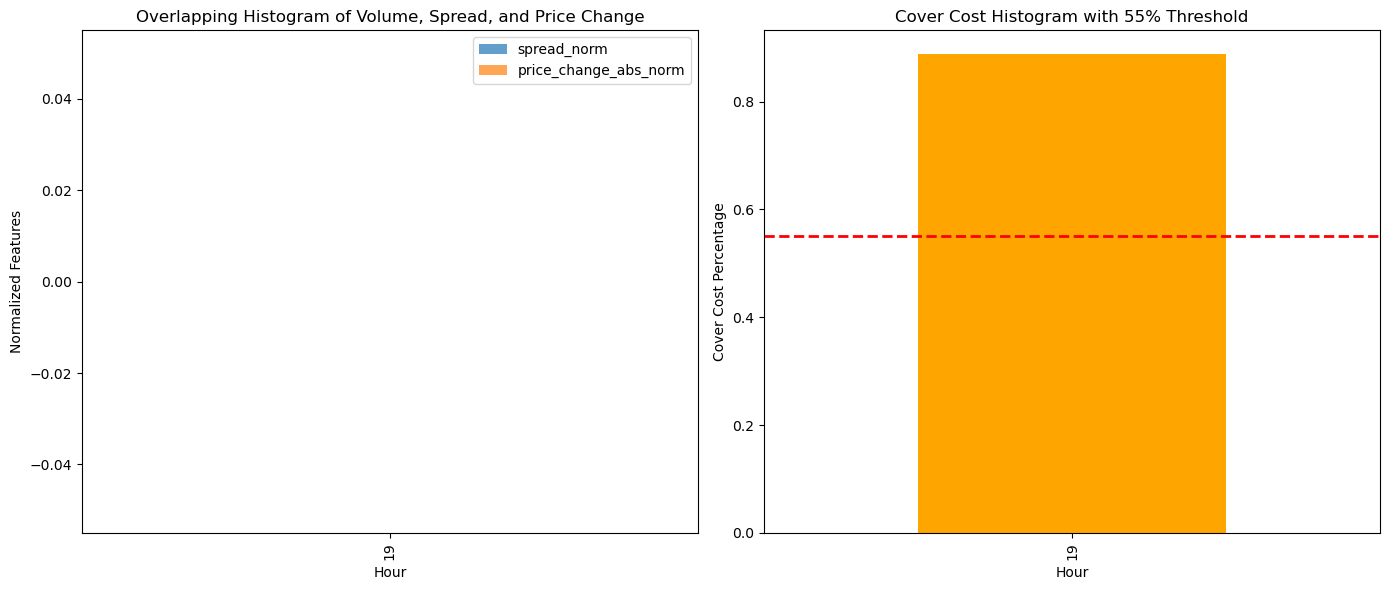

/home/ezemriv/git_projects/ML-Forex-TradingBot-IKBR/evaluate_asset/FinancialInstrumentAnalyzer.py:297: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = self.df.resample(freq).last().dropna()
/home/ezemriv/git_projects/ML-Forex-TradingBot-IKBR/evaluate_asset/FinancialInstrumentAnalyzer.py:297: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = self.df.resample(freq).last().dropna()
/home/ezemriv/git_projects/ML-Forex-TradingBot-IKBR/evaluate_asset/FinancialInstrumentAnalyzer.py:297: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = self.df.resample(freq).last().dropna()


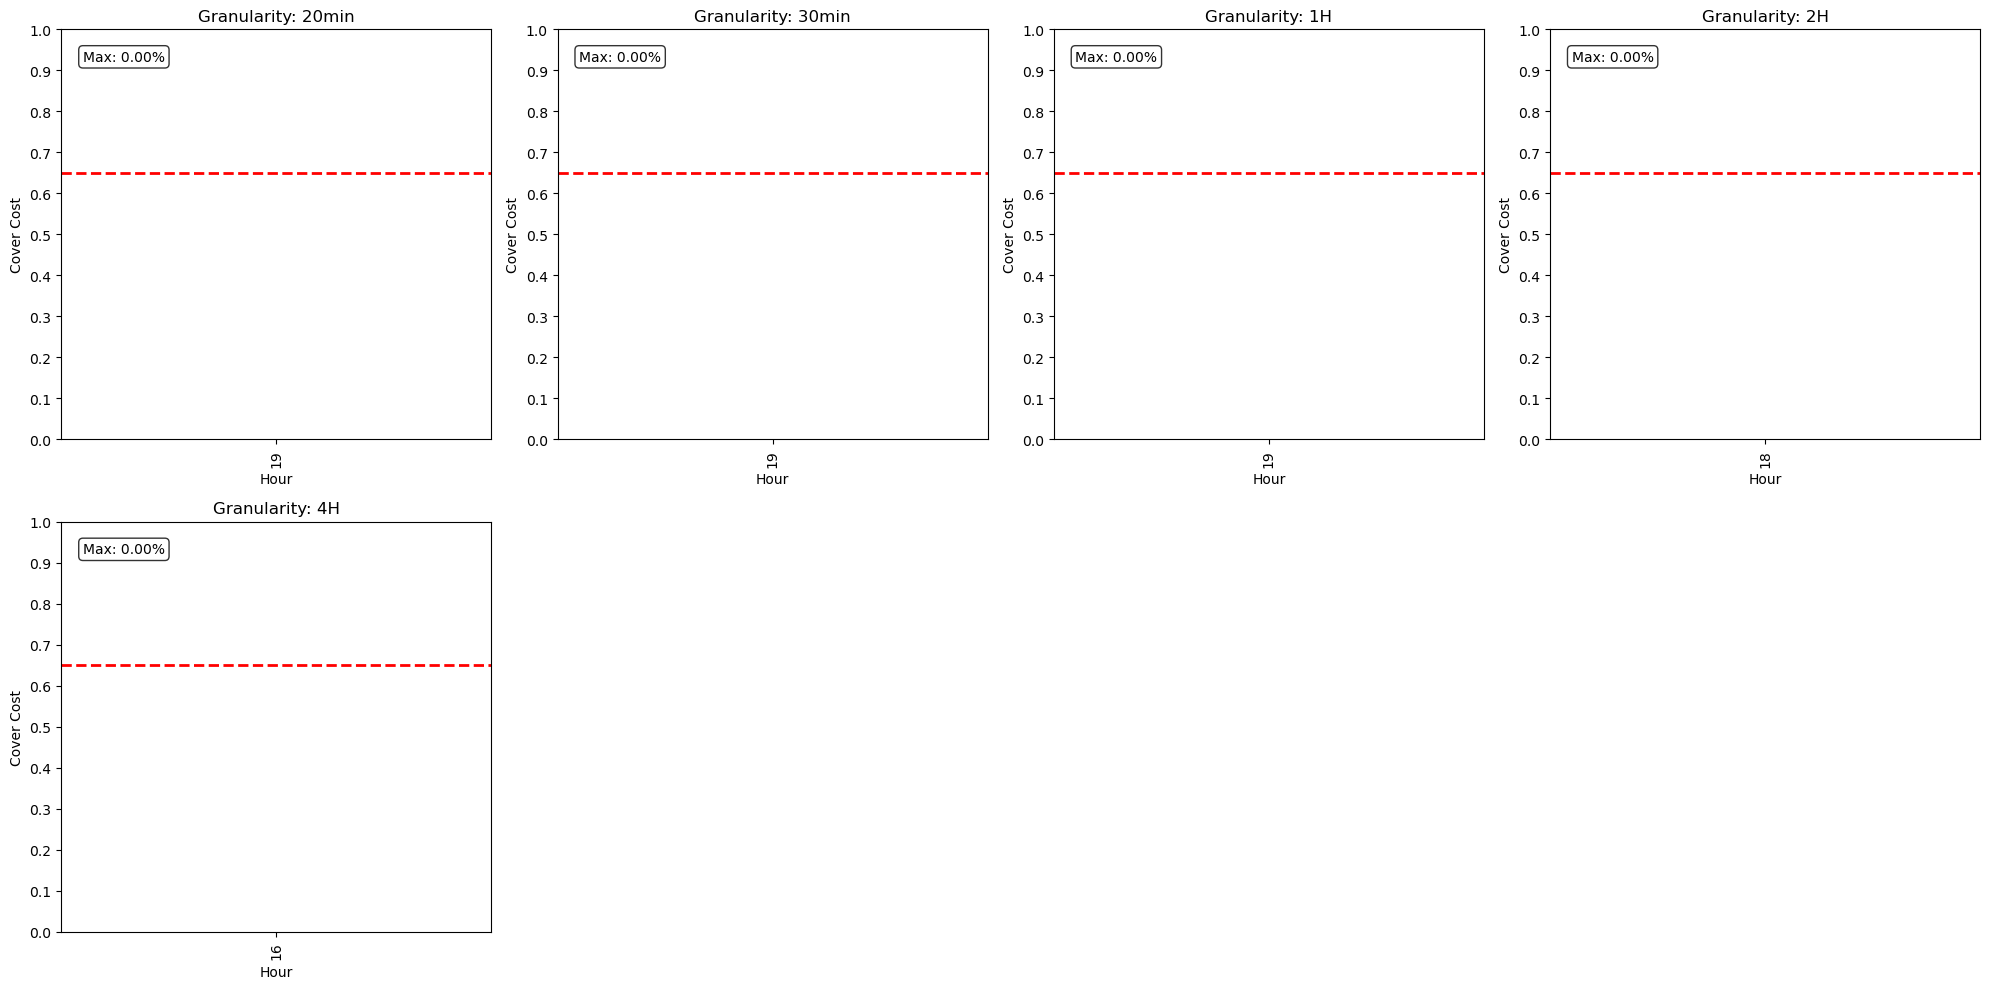

In [49]:
# Create an instance of TradingHourAnalyzer
analyzer = TradingHourAnalyzer(data, timezone='America/New_York')

# Detect busy trading hours
analyzer.detect_busy_trading_hours(threshold=0.55)

# Analyze the best granularity for trading
analyzer.hours_granularity(freq_list=['20min', '30min', '1H', '2H', '4H'], threshold=0.65)